# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import sys
#Import Numpy
import numpy as np
#Import Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#Import matplot
import matplotlib
import matplotlib.pyplot as plt
# Set plotting options
%matplotlib inline

import random
import copy
import time
import datetime

from collections import namedtuple, deque

In [2]:
from model import Actor, Critic
from ddpq_agent import Agent, OUNoise, ReplayBuffer
from ddpq_agent import Agent, LR_ACTOR, LR_CRITIC, BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR_ACTOR, LR_CRITIC, WEIGHT_DECAY  

In [3]:
from unityagents import UnityEnvironment

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [4]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [7]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### Intializing the agent

In [7]:
agent = Agent()

### Training

In [9]:
# DDPG function
def ddpg(num_episodes=100000, max_t=1000, print_every=5):
    
    #Creating an array to store the reward for the winning agent(trying to maximise)
    winning_scores_list = []
    
    #Creating an array to store the reward for the losing agent
    loosing_scores_list = []
    
    #Creating an array to store 100 most recent episodes scores of winning agent (trying to maximise)
    accumulated_winning_scores_list = deque(maxlen=100)
    
    #Creating an array to store 100 most recent episodes scores of losing agent 
    accumulated_loosing_scores_list = deque(maxlen=100)
    
    #Creating an array of 100 most recent scores of winning agent and get an average and store it as one value.
    winning_scores_window_list = []
    
    
    #Creating an array of 100 most recent scores of losing agent and get an average and store it as one value.
    loosing_scores_window_list = []
    
    for i_episode in range(1, num_episodes+1):
        

        #Mentioned in the markdown, while training train_mode should be set to True
        env_info = env.reset(train_mode=True)[brain_name]
        
        #Asking the environment to send the current state 
        states = env_info.vector_observations
        
        # Resetting the agent 
        agent.reset()
        
        # initialize the score (for each agent)
        
        #Since we have 2 agents, we need to set the score of each agent to 0.
        single_scores = np.zeros(num_agents)
        
        #Creating a loop for 1 to 1001 time steps, if time step limit is exceeded; ;
        #it means the agent is stuck, break the loop
        for t in range(max_t):
            
            
            #Returns actions for a given under a given policy
            actions = agent.act(states, add_noise=True)
            
            #Taking the actions
            env_info = env.step(actions)[brain_name]
            
            #After taking the next action we get -> next state for all 2 agents.
            next_states = env_info.vector_observations
            
            #After taking the next action we get -> reward for all 2 agents
            rewards = env_info.rewards
            
            #After taking the next action we get -> Check whether the episode has ended or not; if ended then True
            dones = env_info.local_done
            
            # Agent storing the states, reward, next_states in the replay_buffer, so that it can reshuffle and learn from it without any bias.
            agent.step(states, actions, rewards, next_states, dones)
            
            #After every 15 time steps, agents accesses replay_buffer and learns from it.
            if t % 15 == 0:
                
                #Learns from samples
                agent.learning_from_samples()
  
            #Assigning the new state as current state; meaning changing the state
            states = next_states

            #Adding the received reward to the score
            single_scores += rewards

            #Check if the episode has ended or not
            #Using np.any: Tells us Test whether any array element along a given axis evaluates to True.
            #Using any since there are 2 agents, so we have to check whether any of them is true
            if np.any(dones):
                
                #If done, then come out of the timestep loop
                break
        
        #To access the last element of the array. We are storing the value -1 as last_element
        last_element = -1

        #single_scores is 2 element array
        #We have to store the maximum score of two agents. We used np.max() to access the max the maximum value of array.
        
        #Adding the maximum value between two scores to winning_scores_list
        winning_scores_list.append(np.max(single_scores))
        
        #Adding the minimum value between two scores to loosing_scores_list
        loosing_scores_list.append(np.min(single_scores))
        
        #Adding the last element to the accumulated_winning_scores
        accumulated_winning_scores_list.append(winning_scores_list[last_element])

        #Adding the last element to the accumulated_loosing_scores
        accumulated_loosing_scores_list.append(loosing_scores_list[last_element])
        
        
        #Preprocessing: We usually used np.mean in the print but it has been done as an extra step.
        
        #Creating an average for the winning agent.
        win_mean = np.mean(accumulated_winning_scores_list)
        
        #Creating an average for the losing agent.
        loose_mean = np.mean(accumulated_loosing_scores_list)
        
        #EXTRA STEP: For better understanding I have ensures that winning_scores_window_list & loosing_scores_window_list
        # have the same dimension as the number of episodes, so it easier to plot & understand.
        
        #Averaging the last 100 episodes scores and stores it in winning_scores_window
        winning_scores_window_list.append(win_mean)
        
        #Averaging the last 100 episdoes scores and storing it in loosing_scores_window
        loosing_scores_window_list.append(loose_mean)
        
        #printing the number to see the progress
        #Because of the extra step, we will now use access the last element, which contains the average score of last 100 episodes.
        print('\rEpisode {}\t Average Score: {:.4f}'.format(i_episode, winning_scores_window_list[last_element]), end="")
        
        
        #After every 5 episodes, the algorithms prints the episode number and the average score
        if i_episode % print_every == 0:
            print('\rEpisode {}\t Average Score: {:.4f}'.format(i_episode, winning_scores_window_list[last_element]))
            
        #After the average_score reaches 0.5, break the loop and save the weights    
        if winning_scores_window_list[last_element] >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(
                  i_episode, winning_scores_window_list[last_element]))
            
            # Saving the models for actor and critic
            torch.save(agent.actor_local.state_dict(), 'saved_actor_model.pth')
            torch.save(agent.critic_local.state_dict(), 'saved_critic_model.pth')
            
            #Breaking the episodes loop
            break
        
            
    return winning_scores_list, loosing_scores_list, winning_scores_window_list
    

In [10]:
winner_agent_score, loser_agent_score, average_score = ddpg()

Episode 5	 Average Score: 0.0000
Episode 10	 Average Score: 0.0000
Episode 15	 Average Score: 0.0000
Episode 20	 Average Score: 0.0000
Episode 25	 Average Score: 0.0000
Episode 30	 Average Score: 0.0000
Episode 35	 Average Score: 0.0000
Episode 40	 Average Score: 0.0000
Episode 45	 Average Score: 0.0000
Episode 50	 Average Score: 0.0000
Episode 55	 Average Score: 0.0000
Episode 60	 Average Score: 0.0000
Episode 65	 Average Score: 0.0000
Episode 70	 Average Score: 0.0000
Episode 75	 Average Score: 0.0000
Episode 80	 Average Score: 0.0000
Episode 85	 Average Score: 0.0000
Episode 90	 Average Score: 0.0000
Episode 95	 Average Score: 0.0000
Episode 100	 Average Score: 0.0000
Episode 105	 Average Score: 0.0000
Episode 110	 Average Score: 0.0000
Episode 115	 Average Score: 0.0000
Episode 120	 Average Score: 0.0000
Episode 125	 Average Score: 0.0000
Episode 130	 Average Score: 0.0000
Episode 135	 Average Score: 0.0000
Episode 140	 Average Score: 0.0000
Episode 145	 Average Score: 0.0000
Episo

Episode 1170	 Average Score: 0.0000
Episode 1175	 Average Score: 0.0000
Episode 1180	 Average Score: 0.0000
Episode 1185	 Average Score: 0.0000
Episode 1190	 Average Score: 0.0000
Episode 1195	 Average Score: 0.0000
Episode 1200	 Average Score: 0.0000
Episode 1205	 Average Score: 0.0000
Episode 1210	 Average Score: 0.0000
Episode 1215	 Average Score: 0.0000
Episode 1220	 Average Score: 0.0000
Episode 1225	 Average Score: 0.0000
Episode 1230	 Average Score: 0.0000
Episode 1235	 Average Score: 0.0000
Episode 1240	 Average Score: 0.0000
Episode 1245	 Average Score: 0.0000
Episode 1250	 Average Score: 0.0000
Episode 1255	 Average Score: 0.0000
Episode 1260	 Average Score: 0.0000
Episode 1265	 Average Score: 0.0000
Episode 1270	 Average Score: 0.0000
Episode 1275	 Average Score: 0.0000
Episode 1280	 Average Score: 0.0000
Episode 1285	 Average Score: 0.0000
Episode 1290	 Average Score: 0.0000
Episode 1295	 Average Score: 0.0000
Episode 1300	 Average Score: 0.0000
Episode 1305	 Average Score:

Episode 2305	 Average Score: 0.0000
Episode 2310	 Average Score: 0.0000
Episode 2315	 Average Score: 0.0000
Episode 2320	 Average Score: 0.0000
Episode 2325	 Average Score: 0.0000
Episode 2330	 Average Score: 0.0000
Episode 2335	 Average Score: 0.0000
Episode 2340	 Average Score: 0.0000
Episode 2345	 Average Score: 0.0000
Episode 2350	 Average Score: 0.0000
Episode 2355	 Average Score: 0.0000
Episode 2360	 Average Score: 0.0000
Episode 2365	 Average Score: 0.0000
Episode 2370	 Average Score: 0.0000
Episode 2375	 Average Score: 0.0000
Episode 2380	 Average Score: 0.0000
Episode 2385	 Average Score: 0.0000
Episode 2390	 Average Score: 0.0000
Episode 2395	 Average Score: 0.0000
Episode 2400	 Average Score: 0.0000
Episode 2405	 Average Score: 0.0000
Episode 2410	 Average Score: 0.0037
Episode 2415	 Average Score: 0.0037
Episode 2420	 Average Score: 0.0037
Episode 2425	 Average Score: 0.0037
Episode 2430	 Average Score: 0.0037
Episode 2435	 Average Score: 0.0037
Episode 2440	 Average Score:

Episode 3440	 Average Score: 0.0000
Episode 3445	 Average Score: 0.0000
Episode 3450	 Average Score: 0.0000
Episode 3455	 Average Score: 0.0000
Episode 3460	 Average Score: 0.0000
Episode 3465	 Average Score: 0.0000
Episode 3470	 Average Score: 0.0000
Episode 3475	 Average Score: 0.0000
Episode 3480	 Average Score: 0.0000
Episode 3485	 Average Score: 0.0000
Episode 3490	 Average Score: 0.0000
Episode 3495	 Average Score: 0.0000
Episode 3500	 Average Score: 0.0000
Episode 3505	 Average Score: 0.0000
Episode 3510	 Average Score: 0.0000
Episode 3515	 Average Score: 0.0000
Episode 3520	 Average Score: 0.0000
Episode 3525	 Average Score: 0.0000
Episode 3530	 Average Score: 0.0000
Episode 3535	 Average Score: 0.0000
Episode 3540	 Average Score: 0.0000
Episode 3545	 Average Score: 0.0000
Episode 3550	 Average Score: 0.0000
Episode 3555	 Average Score: 0.0000
Episode 3560	 Average Score: 0.0000
Episode 3565	 Average Score: 0.0000
Episode 3570	 Average Score: 0.0000
Episode 3575	 Average Score:

### Plotting 

For clarity, we will plot two graphs:

- Score: The maximum score per episode is plotted 

- Average Score: The average score for the last 100 episodes is plotted 

- Winner vs Loser: Winner agent score is plotted with loser agent score against episodes


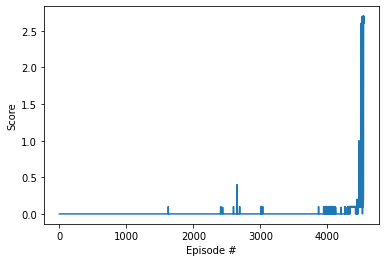

In [14]:
# plot scores winner score(max score per episode) over episode
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(winner_agent_score)+1), winner_agent_score)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

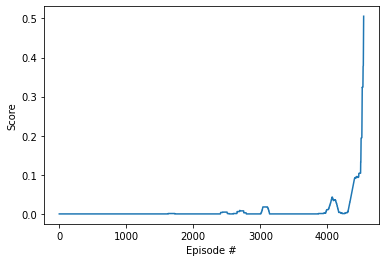

In [13]:
# plot of average score(last 100 episodes) over episode
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(winner_agent_score)+1)), average_score)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

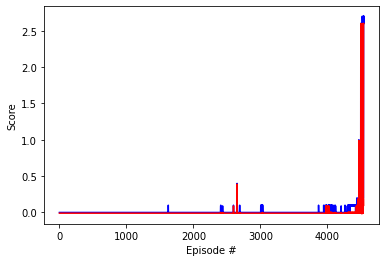

In [23]:
# plot scores of winner agent vs loser agent
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(winner_agent_score)+1), winner_agent_score, 'b-')
plt.plot(np.arange(1, len(loser_agent_score)+1), loser_agent_score, 'r-')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [25]:
env.close()